# Markov Chain Ensembles 

This notebook provides some basic setups for starting to explore Markov chain sampling of districting plans using the GerryChain package. Some additional documentation for the software components is here: https://www.math.wsu.edu/faculty/ddeford/GerryChain_Guide.pdf and the official documentation and API also has several useful examples: https://github.com/mggg/gerrychain as well as these: https://github.com/drdeford/gerrychain-templates. You might also find it useful to go through the exercises suggested here:https://github.com/vrdi/GerryChain-BootCamp from a previous VRDI bootcamp. 

The first key object of the GerryChain package is the Partition class, which consists of the dual graph, an assignment, and a set of updaters. We've already spent plenty of time looking at dual graphs but the other two objects are new. An assignment is just a dictionary that maps every node in the graph to its district assignment. In the Partition constructor you can also just pass in the name of a column of data stored on the graph. Updaters are functions that take a Partition as input and return a value. These are intended to be evaluated at every step of the Markov chain and can be used to provide auxilliary values to other components of the Markov chain. 

In [54]:
import matplotlib.pyplot as plt

import networkx as nx

from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from functools import partial
import pandas
from gerrychain.tree import recursive_tree_part

from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper

import geopandas as gpd

import os

from gerrychain.constraints.contiguity import contiguous_components, contiguous

from gerrychain.updaters import cut_edges

from gerrychain.tree import bipartition_tree, find_balanced_edge_cuts_memoization

#import maup

import numpy as np

import pandas as pd

import geopandas as gpd

import random

import math


In [3]:
Precincts = gpd.read_file("./WA/WA_2020/WA_2020_w_plans_votes/WA_2020_w_plans_votes_t.shp")
graph = Graph.from_json("./WA/WA_2020/WA_2020_w_plans_votes/WA_2020_w_plans_votes_t.json")

In [6]:
graph.nodes()[0]

{'boundary_node': False,
 'area': 2.3383773000024948e-05,
 'STATEFP20': '53',
 'COUNTYFP20': '041',
 'VTDST20': '000114',
 'GEOID20': '53041000114',
 'VTDI20': 'A',
 'NAME20': 'CENTRALIA 14',
 'NAMELSAD20': 'CENTRALIA 14 Voting District',
 'LSAD20': 'V2',
 'MTFCC20': 'G5240',
 'FUNCSTAT20': 'N',
 'ALAND20': 198831,
 'AWATER20': 0,
 'INTPTLAT20': '+46.6938564',
 'INTPTLON20': '-122.9604254',
 'FILEID': 'PLST',
 'STUSAB': 'WA',
 'SUMLEV': '700',
 'GEOVAR': '00',
 'GEOCOMP': '00',
 'CHARITER': '000',
 'LOGRECNO': '0042465',
 'GEOID': '7000000US53041000114',
 'GEOCODE': '53041000114',
 'REGION': '4',
 'DIVISION': '9',
 'STATE': '53',
 'STATENS': '01779804',
 'COUNTY': '041',
 'COUNTYCC': 'H1',
 'COUNTYNS': '01531927',
 'CBSA': '16500',
 'MEMI': '2',
 'CSA': '500',
 'METDIV': '99999',
 'VTD': '000114',
 'VTDI': 'A',
 'AREALAND': 198831,
 'AREAWATR': 0,
 'BASENAME': 'CENTRALIA 14',
 'NAME': 'CENTRALIA 14 Voting District',
 'FUNCSTAT': 'N',
 'POP100': 0,
 'HU100': 0,
 'INTPTLAT': '+46.6938564

In [4]:

def county_splits(partition, df=Precincts):
    df["current"] = df.index.map(partition.assignment)

    counties = sum(df.groupby("COUNTYFP20")['current'].nunique()>1)
    return counties

def num_comp(part):
  return sum( [.45 < x < .55 for x in part['PRS'].percents('Democratic')])

def nearest_comp_dist(part):

  percs = sorted(list(part['PRS'].percents('Democratic')))

  dists = []

  for x in percs:
    if x < .45:
      dists.append(.45-x)
    elif x < .55:
      dists.append(100)
    else:
      dists.append(x-.55)

  return min(dists)

def improve_comp(part):

  if num_comp(part) > num_comp(part.parent):
    return True

  elif nearest_comp_dist(part) < nearest_comp_dist(part.parent):
    return True

  else:
    if random.random() < .05:
      return True

    else:
      return False

for node in graph.nodes():
    graph.nodes[node]['nWPOP'] = graph.nodes[node]['P0010001'] -  graph.nodes[node]['P0010003']
    graph.nodes[node]['nWVAP'] = graph.nodes[node]['P0030001'] -  graph.nodes[node]['P0030003']


In [10]:

election_names = [
    "PRS",
    "LTG",
    "SOS",
    "TRE",
    "AUD",
    "ATG"
]

num_elections = len(election_names)

election_columns = [
    ["G20PRSBIDE",
"G20PRSTRUM"],
["G20LTGHECK",
"G20LTGLIIA"],
["G20SOSWYMA",
"G20SOSTARL"],
["G20TREPELL",
"G20TREDAVI"],
["G20AUDMCCA",
"G20AUDLEYB"],
["G20ATGFERG",
"G20ATGLARK"],
]

my_updaters = {
    "population": updaters.Tally("POP100", alias="population"),
    "cut_edges": cut_edges,
    "PP":polsby_popper,
    "nWPOP": Election("nWPOP",{"nWPOP":"nWPOP",'WPOP':"P0010003"}),
    "nWVAP": Election("nWVAP",{"nWVAP":"nWVAP",'WVAP':"P0030003"}),
    "county_splits": county_splits
}


elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)

total_population = 0

for node in graph.nodes():
  total_population += graph.nodes()[node]['POP100']




We'll start by making several Partitions for the proposed plans already on the data. 

In [11]:
FPart = GeographicPartition(graph,"Fain",my_updaters)
WPart = GeographicPartition(graph,"Walkinshaw",my_updaters)
GPart = GeographicPartition(graph,"Graves",my_updaters)
SPart = GeographicPartition(graph,"Sims",my_updaters)
EPart = GeographicPartition(graph,"CD",my_updaters)





We can also build a dictionary to make a new assignment using a recursive spanning tree method. 

In [12]:
tree_seed = recursive_tree_part(graph, range(10),total_population/10 , "POP100", .02, 1)
tree_seed

{12: 0,
 14: 0,
 15: 0,
 18: 0,
 170: 0,
 171: 0,
 173: 0,
 175: 0,
 178: 0,
 180: 0,
 181: 0,
 182: 0,
 183: 0,
 185: 0,
 186: 0,
 187: 0,
 189: 0,
 194: 0,
 215: 0,
 217: 0,
 218: 0,
 220: 0,
 226: 0,
 228: 0,
 230: 0,
 231: 0,
 234: 0,
 235: 0,
 236: 0,
 243: 0,
 249: 0,
 251: 0,
 252: 0,
 253: 0,
 254: 0,
 256: 0,
 257: 0,
 260: 0,
 261: 0,
 262: 0,
 263: 0,
 264: 0,
 265: 0,
 266: 0,
 267: 0,
 268: 0,
 269: 0,
 270: 0,
 271: 0,
 272: 0,
 273: 0,
 274: 0,
 275: 0,
 286: 0,
 288: 0,
 289: 0,
 290: 0,
 291: 0,
 292: 0,
 293: 0,
 294: 0,
 295: 0,
 296: 0,
 298: 0,
 299: 0,
 300: 0,
 301: 0,
 302: 0,
 303: 0,
 304: 0,
 305: 0,
 307: 0,
 308: 0,
 309: 0,
 310: 0,
 313: 0,
 314: 0,
 315: 0,
 316: 0,
 317: 0,
 319: 0,
 320: 0,
 321: 0,
 322: 0,
 323: 0,
 324: 0,
 325: 0,
 326: 0,
 327: 0,
 328: 0,
 329: 0,
 330: 0,
 332: 0,
 333: 0,
 334: 0,
 335: 0,
 336: 0,
 337: 0,
 338: 0,
 339: 0,
 340: 0,
 341: 0,
 342: 0,
 343: 0,
 344: 0,
 345: 0,
 346: 0,
 347: 0,
 348: 0,
 349: 0,
 350: 0,
 352:

In [13]:

TPart = GeographicPartition(graph,tree_seed,my_updaters)
proposed_plans = [FPart,WPart,GPart,SPart,EPart,TPart]
plan_names = ["Fain","Walkinshaw","Graves","Sims","Enacted","Tree"]

clist = ['green','hotpink','orange','purple','gray','yellow']

Now that we have some Partitions that we can use as starting points we need to look at the next important GerryChain class, the MarkovChain. The MarkovChain class also takes several inputs. The simplest ones are the number of steps to take and the initial plan, which is a Partition object. It also needs three types of functions: a proposal, a list of binary constraints, and an acceptance function. Proposals perform the actual algorithmic Markov chain procedure, taking the current Partition as input and returning a new proposed Partition. Binary constraints are Boolean functions that take a Partition as input and output whether or not the Partition satisfies a particular rule like satisfying population balance or compactness bounds. Finally, acceptance functions are used in the Metropolis-Hasting procedure to change the target distribution. Like constraints they are Boolean but rather than rejecting the proposal if it fails the Markov chain simply remains in its current state. 

We'll start with some simple examples on the grid with built-in functions before trying out some more complex experiments. 

In [15]:
grid = Graph.from_json("./Dual_Graphs/orange_pink_grid.json")

In [16]:
grid_updaters = {
    "population": updaters.Tally("Population", alias="population"),
    "cut_edges": cut_edges,
    "OP": Election("OP",{"O":"orange",'P':"pink"})}


first_partition = Partition(grid, 'D5',grid_updaters)

In [20]:
grid_flip_chain1 = MarkovChain(
    proposal=propose_random_flip,
    constraints=[constraints.contiguous],
    accept=accept.always_accept,
    initial_state=first_partition,
    total_steps=10
  )


Note that the MarkovChain is an enumerator - the states aren't actually generated until we ask for them: 

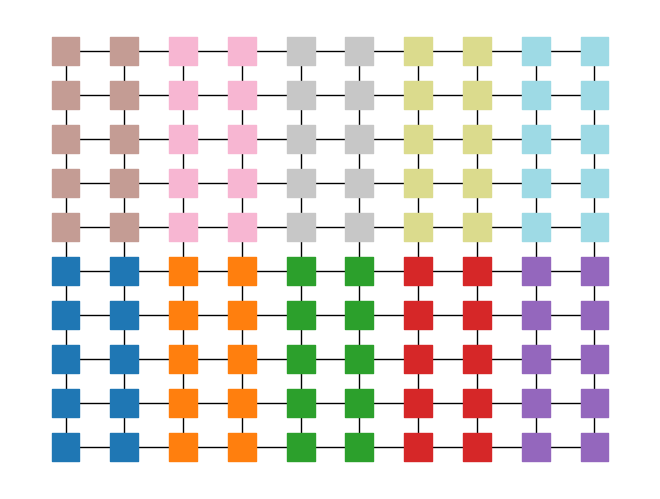

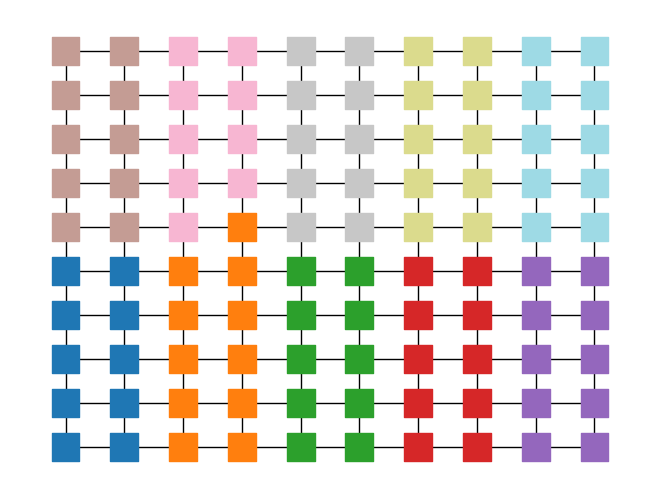

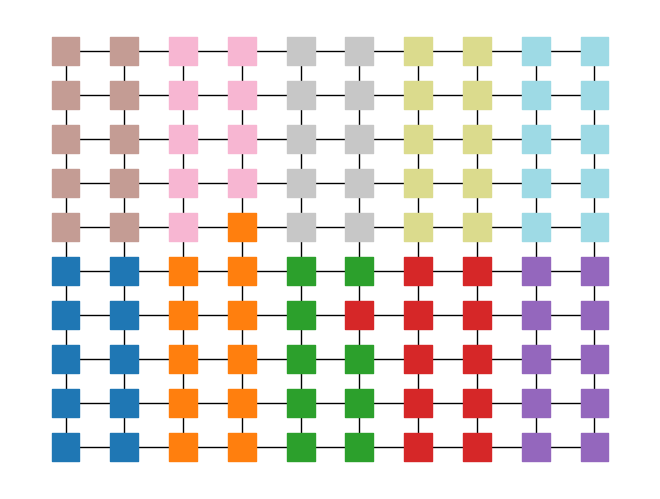

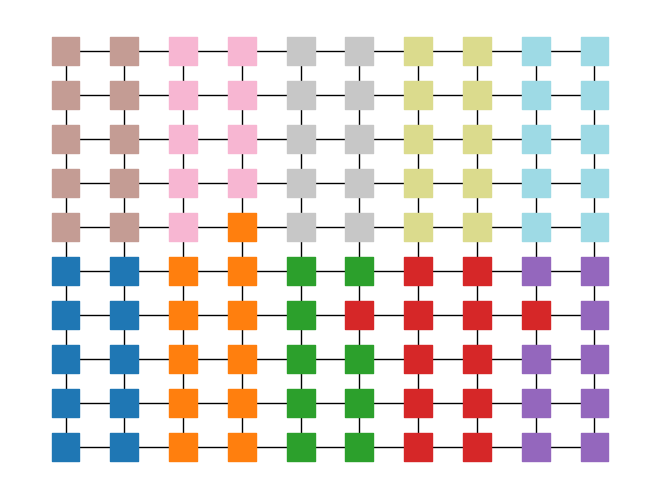

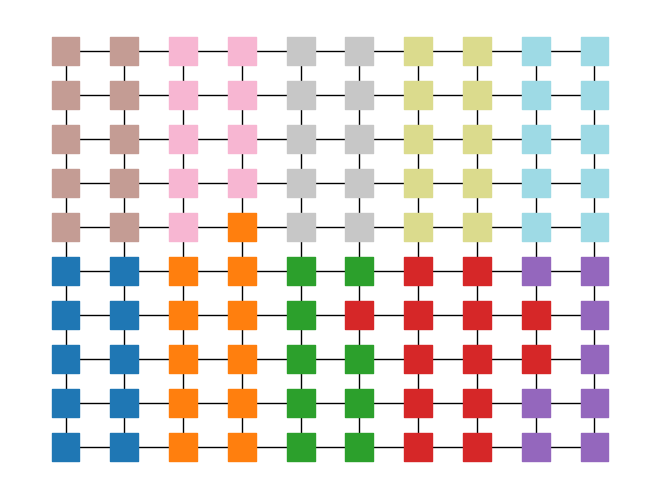

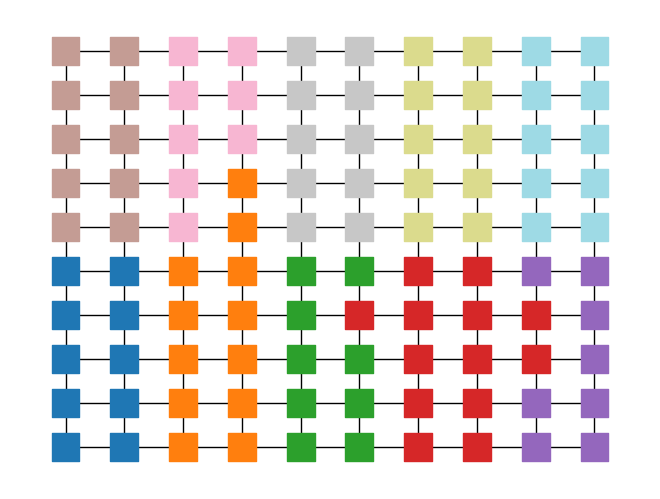

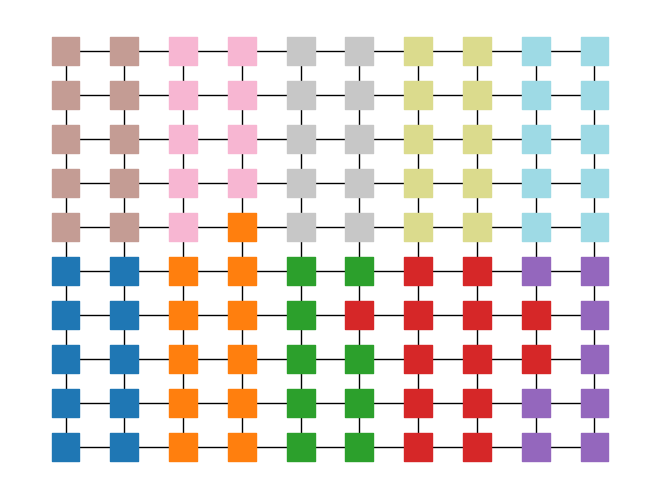

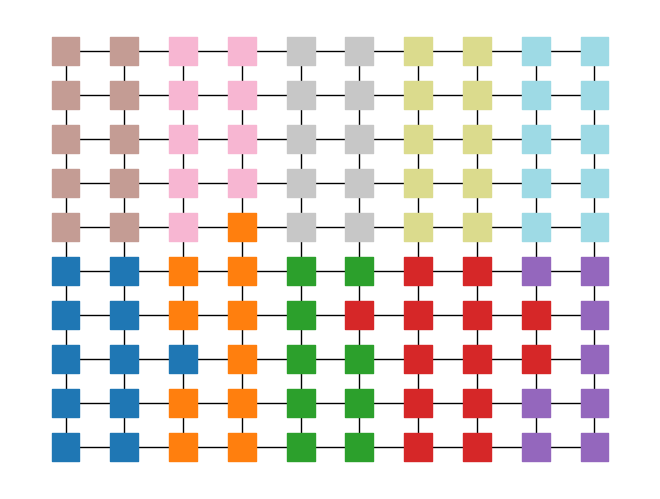

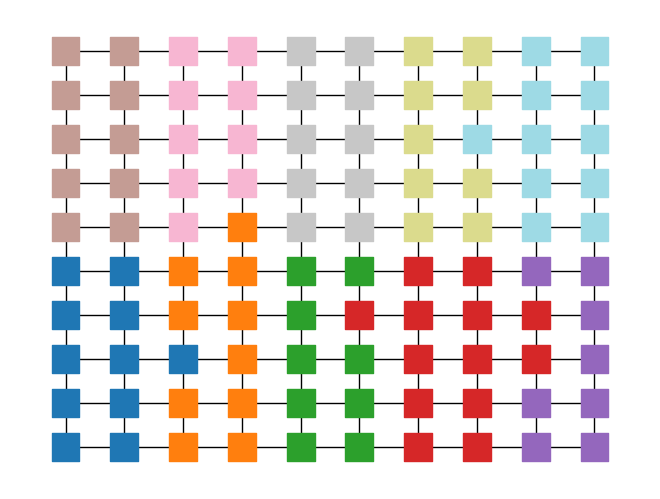

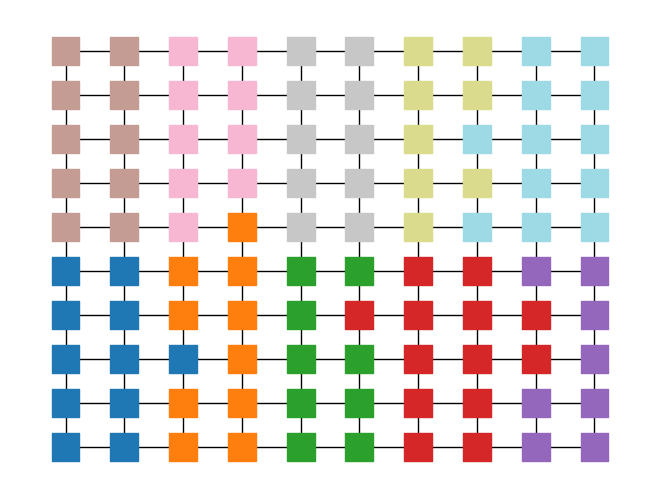

In [21]:
for part in grid_flip_chain1:
    ad = dict(part.assignment)

    nx.draw(grid,pos={x:(grid.nodes()[x]['C_X'],grid.nodes()[x]['C_Y']) for x in grid.nodes()},node_color=[ad[x] for x in grid.nodes()],node_shape='s',node_size=400,cmap='tab20')
    plt.show()

Now let's ramp up the length and just look at the final state (adding a small population constraint so none of the colors vanish): 

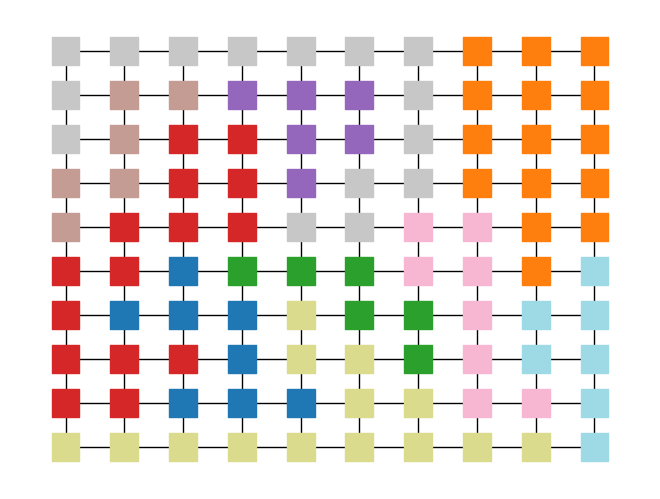

In [26]:
grid_flip_chain2 = MarkovChain(
    proposal=propose_random_flip,
    constraints=[constraints.contiguous,constraints.within_percent_of_ideal_population(first_partition, .5)],
    accept=accept.always_accept,
    initial_state=first_partition,
    total_steps=100000
  )

for part in grid_flip_chain2:
    pass

    

ad = dict(part.assignment)

nx.draw(grid,pos={x:(grid.nodes()[x]['C_X'],grid.nodes()[x]['C_Y']) for x in grid.nodes()},node_color=[ad[x] for x in grid.nodes()],node_shape='s',node_size=400,cmap='tab20')
plt.show()

It looks very different than our starting point! Let's do an experiment a few times, starting with the same initial state but varying an upper bound on the compactness. We'll also make a couple of measurements at each step of the chain, including the number of cut edges and some partisan symmetry scores. 

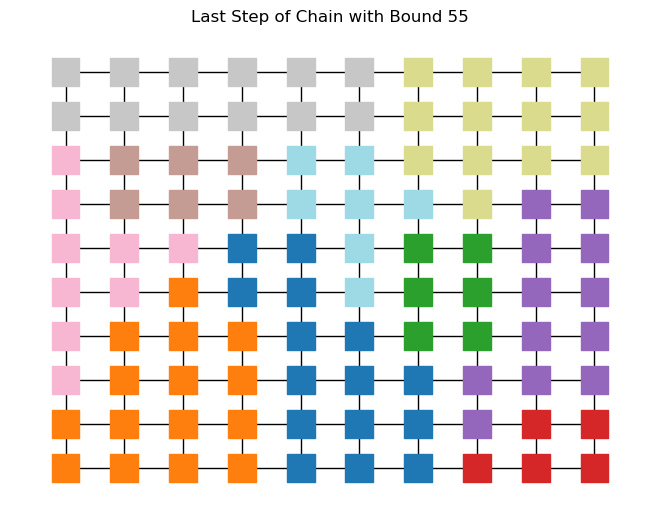

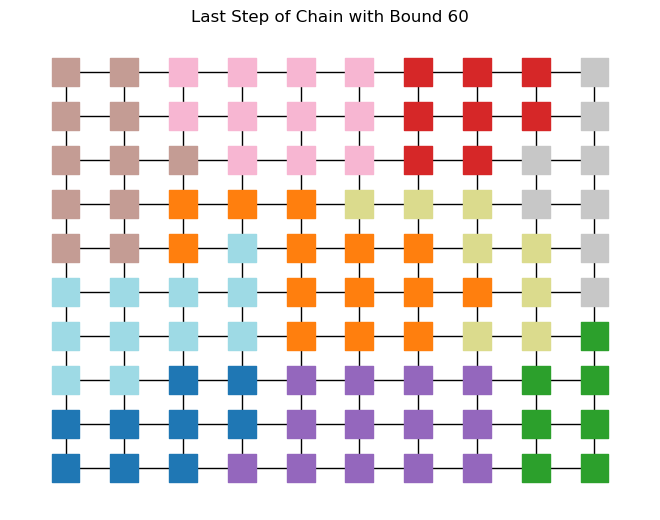

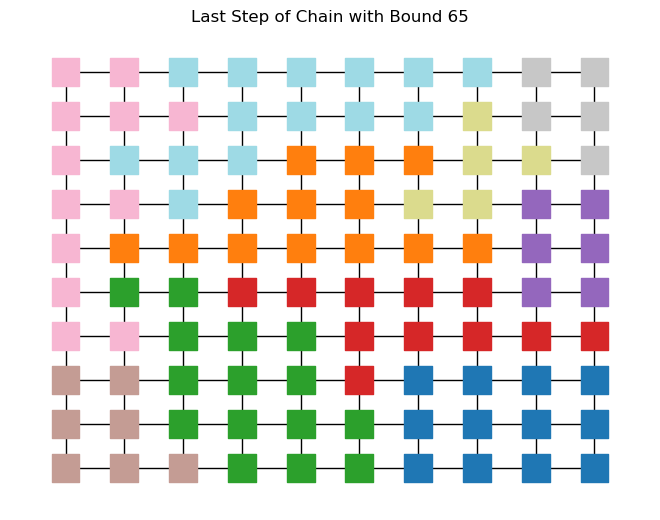

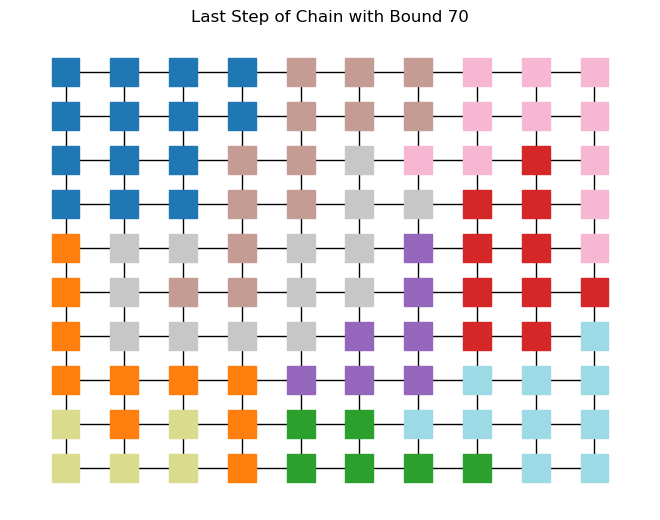

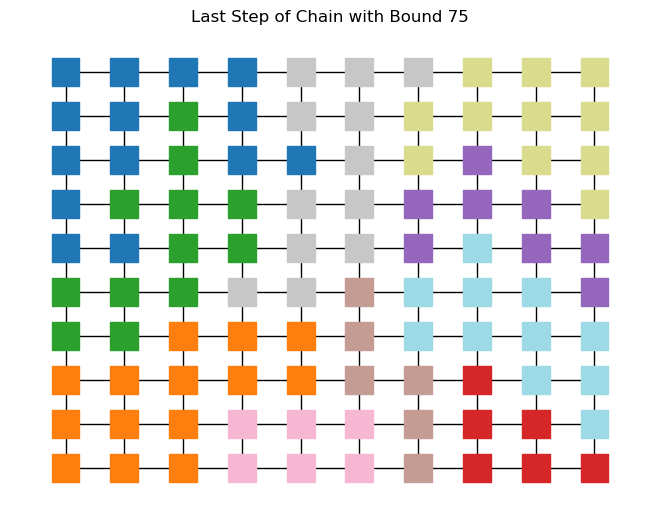

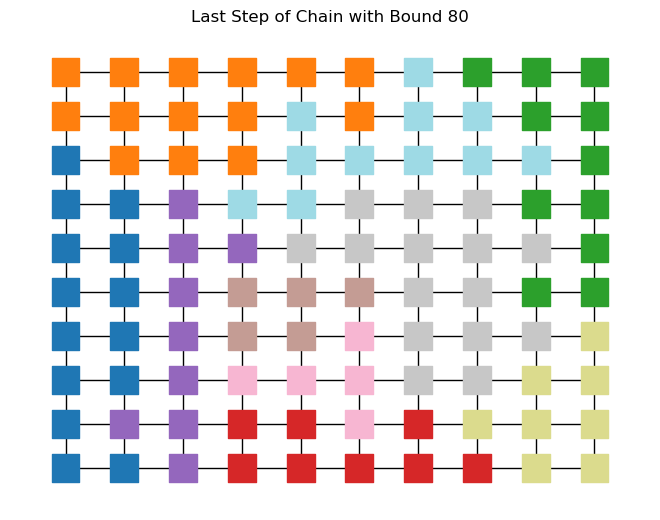

In [38]:

ces = []
mms = []
egs = []

bounds= [55,60,65,70,75,80]

for bound in bounds:
    ces.append([])
    mms.append([])
    egs.append([])
    compactness_bound = constraints.UpperBound(lambda p: len(p["cut_edges"]), bound)
    
    grid_flip_chain3 = MarkovChain(
    proposal=propose_random_flip,
    constraints=[constraints.contiguous,
                 constraints.within_percent_of_ideal_population(first_partition, .5),
                compactness_bound],
    accept=accept.always_accept,
    initial_state=first_partition,
    total_steps=10000
  )

    
    for step,part in enumerate(grid_flip_chain3):
        ces[-1].append(len(part['cut_edges']))
        mms[-1].append(mean_median(part["OP"]))
        egs[-1].append(efficiency_gap(part["OP"]))
        
    
    ad = dict(part.assignment)

    nx.draw(grid,pos={x:(grid.nodes()[x]['C_X'],grid.nodes()[x]['C_Y']) for x in grid.nodes()},node_color=[ad[x] for x in grid.nodes()],node_shape='s',node_size=400,cmap='tab20')
    plt.title(f"Last Step of Chain with Bound {bound}")
    plt.show()


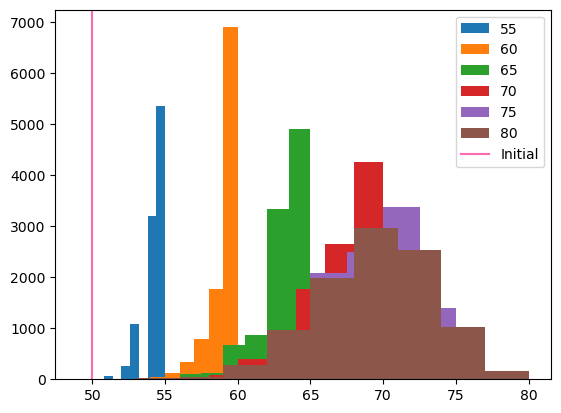

In [34]:
for i in range(6):

    plt.hist(ces[i],label=bounds[i])
    
    
plt.axvline(ces[0][0],label='Initial',color='hotpink')
plt.legend()

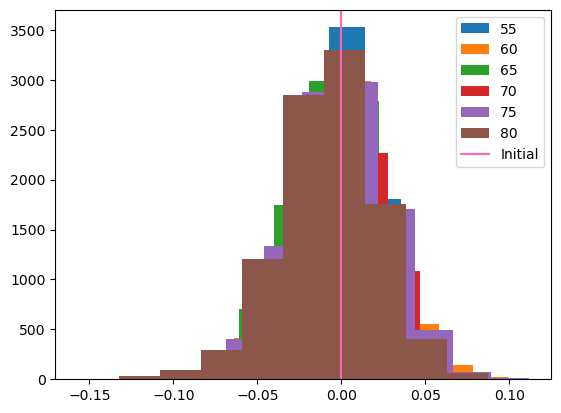

In [36]:
for i in range(6):
    plt.hist(mms[i],label=bounds[i])
    
plt.axvline(mms[0][0],label='Initial',color='hotpink')
plt.legend()

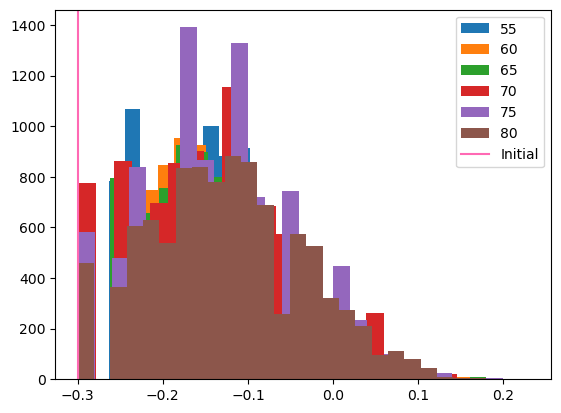

In [39]:
for i in range(6):
    plt.hist(egs[i],label=bounds[i],bins=25)
    
plt.axvline(egs[0][0],label='Initial',color='hotpink')
plt.legend()

Hmmmmm... Looks pretty fair under mean-median but very unfair under efficiency gap!

Now let's build something a little more complex and instead do a simulated annealing run. For this we'll need some helper functions and a new updater.

In [40]:
def adjacent_parts(partition):
    return {
        (x[0], partition.assignment.mapping[x[1]]) for x in partition["cut_edges"]
    }.union(
        {(x[1], partition.assignment.mapping[x[0]]) for x in partition["cut_edges"]}
    )


In [50]:
grid_updaters = {
    "population": updaters.Tally("Population", alias="population"),
    "cut_edges": cut_edges,
    "OP": Election("OP",{"O":"orange",'P':"pink"}),
    "FlippableNodes":adjacent_parts}

first_partition = Partition(grid, 'D5',grid_updaters)


def reversible_propose(partition):
    
    flip_choice = random.choice(list(partition["FlippableNodes"]))
    
    flips = {flip_choice[0]:flip_choice[1]}
    
    return partition.flip(flips)
    

global step 

def annealing_cut_accept2(partition):
    
    boundaries1 = len(partition.parent["FlippableNodes"])
    boundaries2 = len(partition["FlippableNodes"])
    
    base = math.exp(1)

    if (step % 6000) < 1000:
        beta = 0
    elif (step % 6000) < 4000:
        beta = ((step % 6000) - 1000) / 1000
    else:
        beta = 3

    bound = 1
    
    exponent = -beta * (
            len(partition["cut_edges"]) - len(partition.parent["cut_edges"])
        )
    bound = (base ** (exponent)) * (boundaries2 / boundaries1)


    return random.random() < bound


def MH_CE(partition):
    
    boundaries1 = len(partition.parent["FlippableNodes"])
    boundaries2 = len(partition["FlippableNodes"])
            
    beta = 5

    bound = 1
    
    base = math.exp(1)
    
    exponent = -beta * (
            len(partition["cut_edges"]) - len(partition.parent["cut_edges"])
        )
    bound = (base ** (exponent)) * (boundaries2 / boundaries1)


    return random.random() < bound

In [55]:
annealing_chain = MarkovChain(
    proposal=reversible_propose,
    constraints=[
        constraints.within_percent_of_ideal_population(first_partition, 0.2),
          constraints.single_flip_contiguous,
        
    ],
    accept=annealing_cut_accept2,
    initial_state=first_partition,
    total_steps=20000
  )


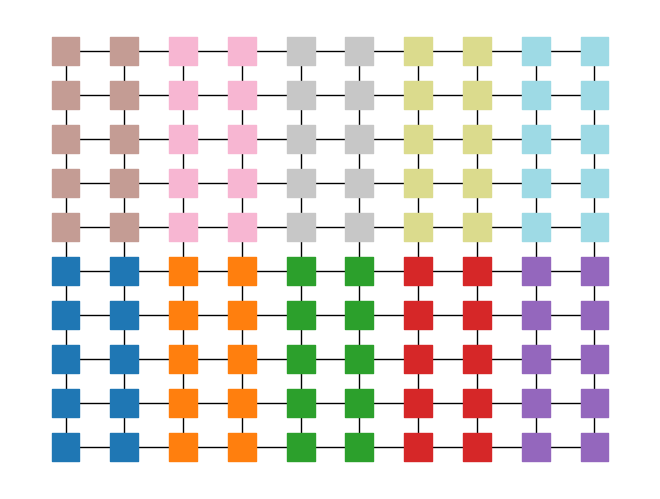

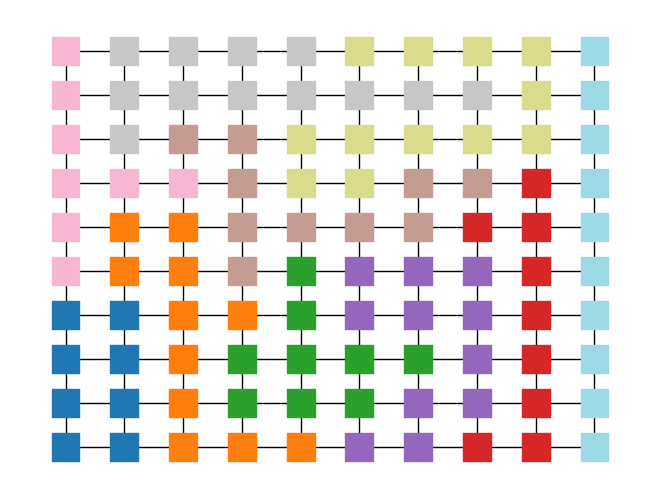

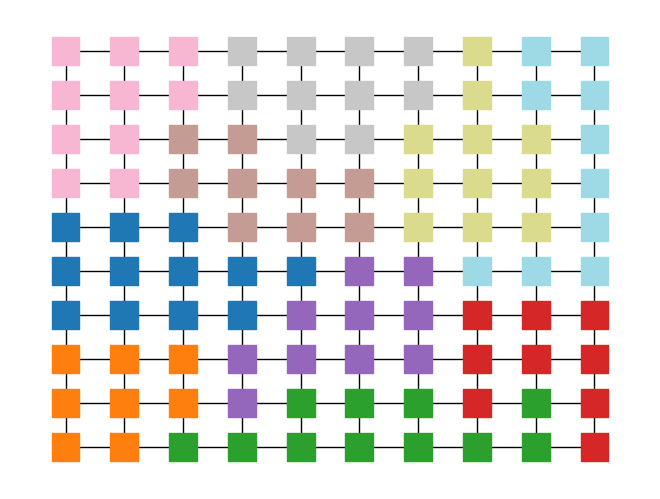

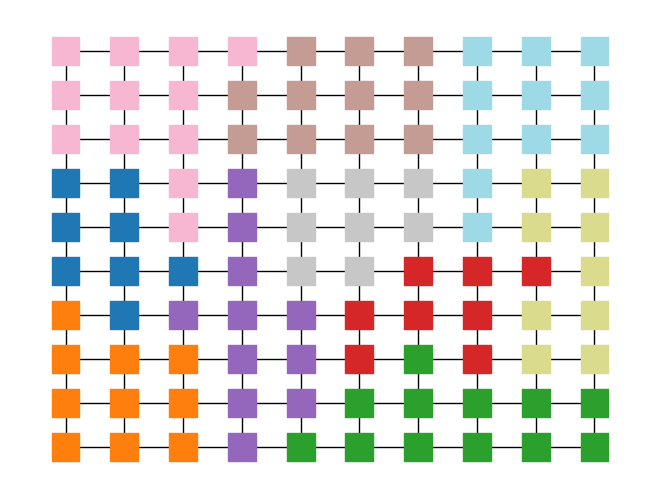

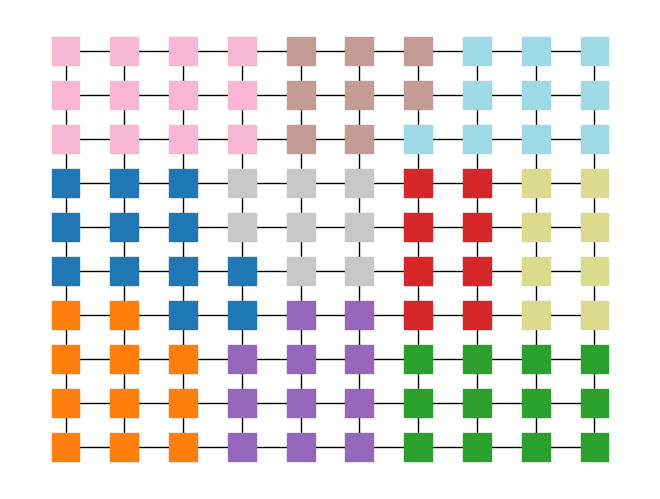

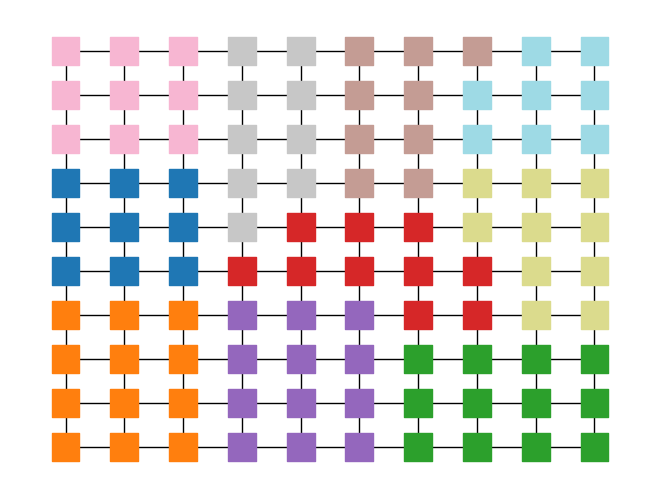

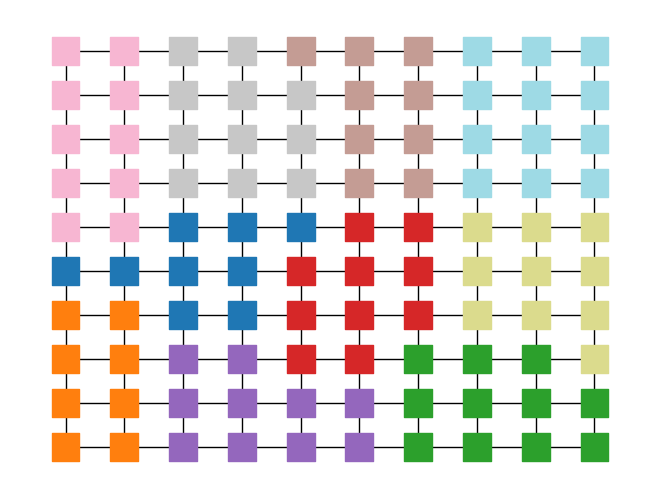

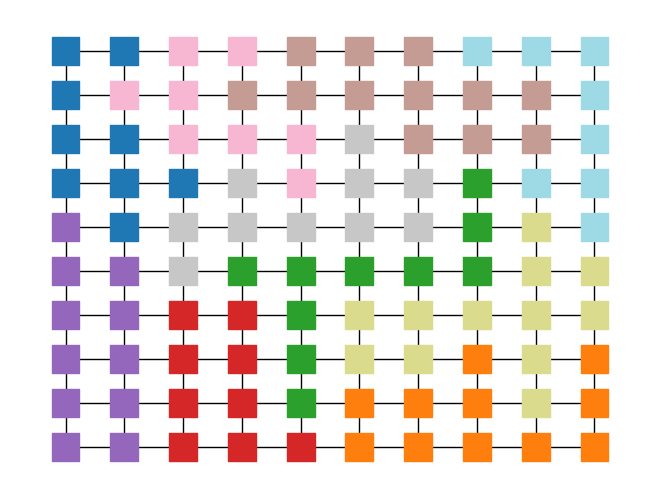

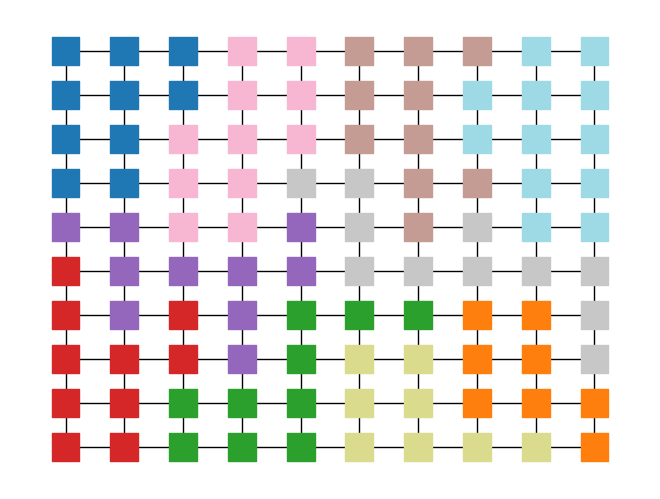

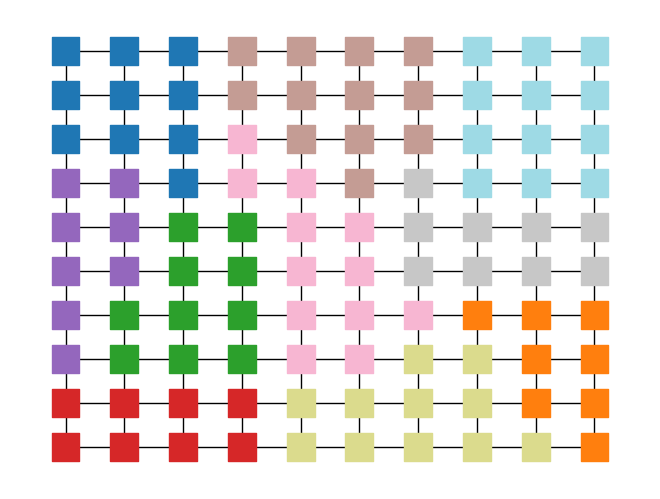

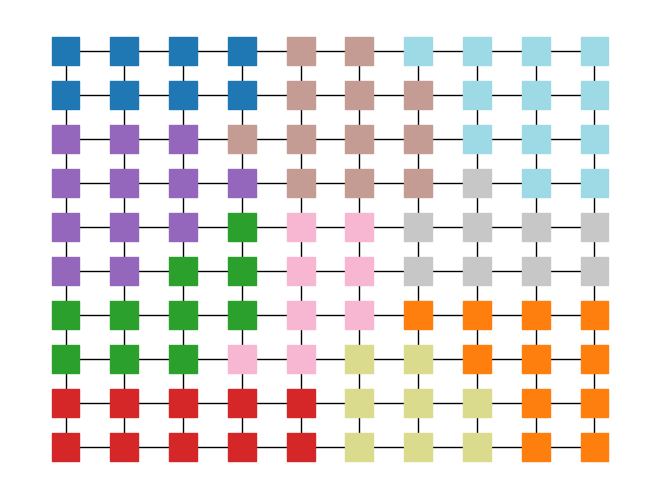

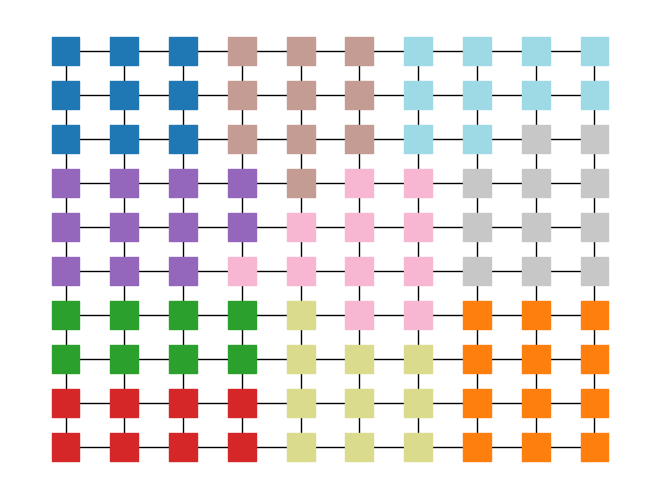

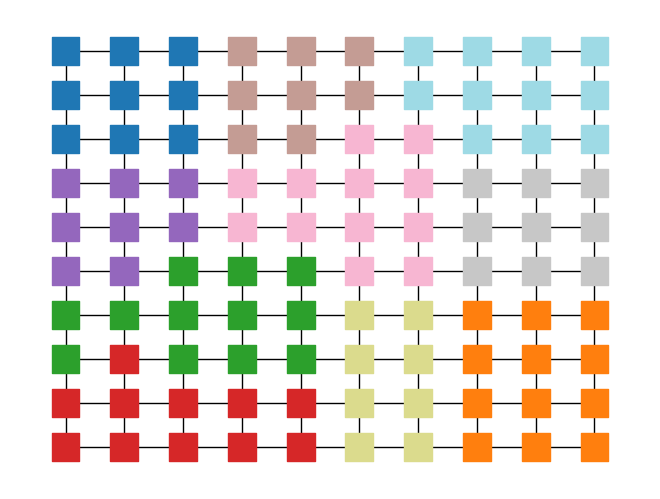

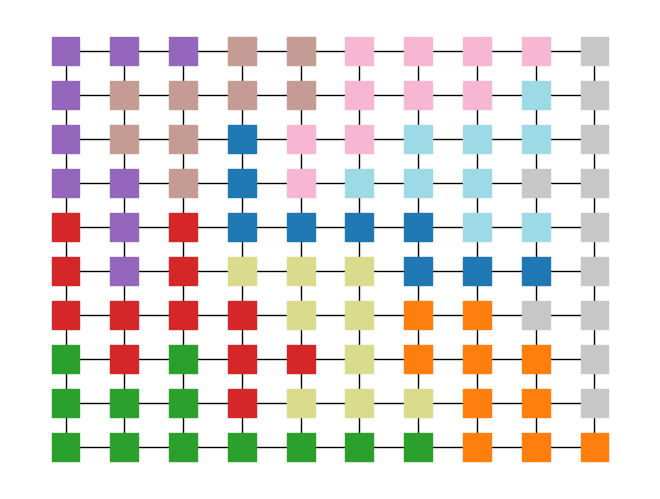

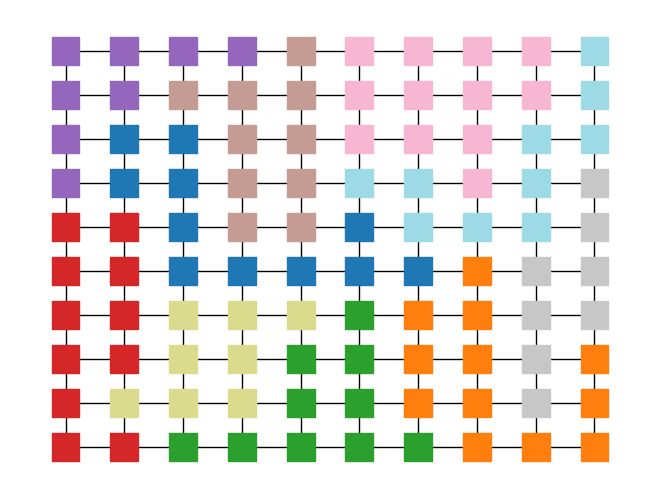

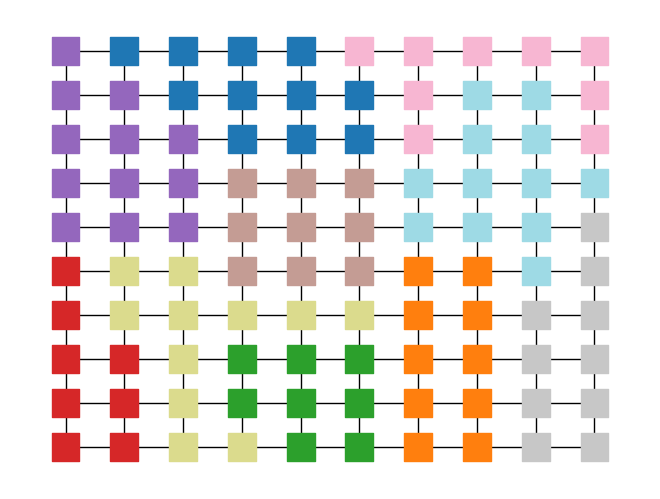

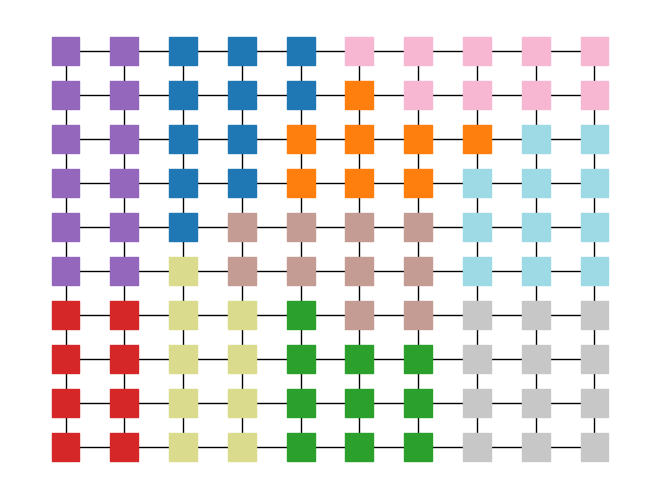

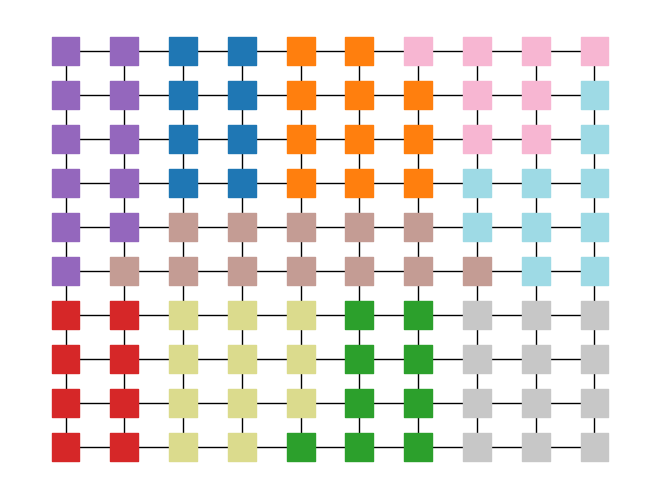

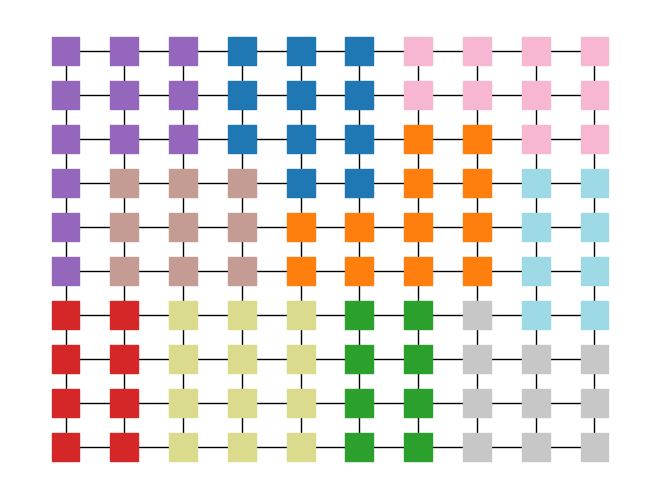

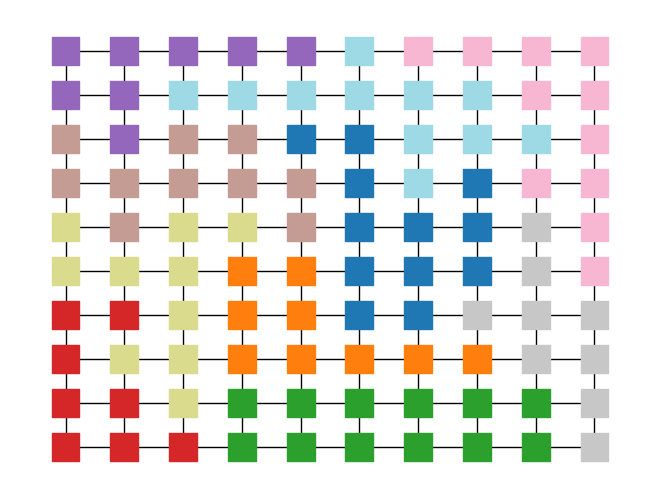

In [60]:
ces = []
mms = []
for step, part in enumerate(annealing_chain):
    ces.append(len(part['cut_edges']))
    mms.append(mean_median(part["OP"]))
    egs.append(efficiency_gap(part["OP"]))
    if step%1000 == 0:
        ad = dict(part.assignment)

        nx.draw(grid,pos={x:(grid.nodes()[x]['C_X'],grid.nodes()[x]['C_Y']) for x in grid.nodes()},node_color=[ad[x] for x in grid.nodes()],node_shape='s',node_size=400,cmap='tab20')
        plt.show()


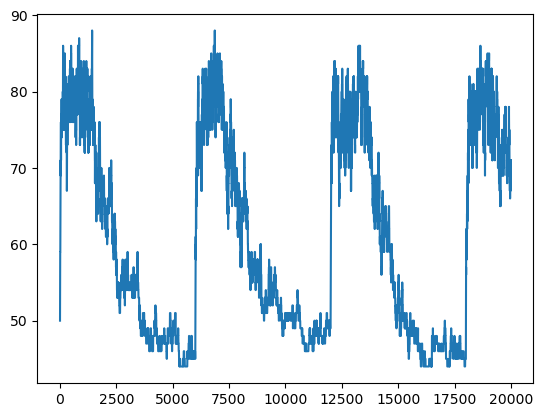

In [57]:
plt.plot(ces)

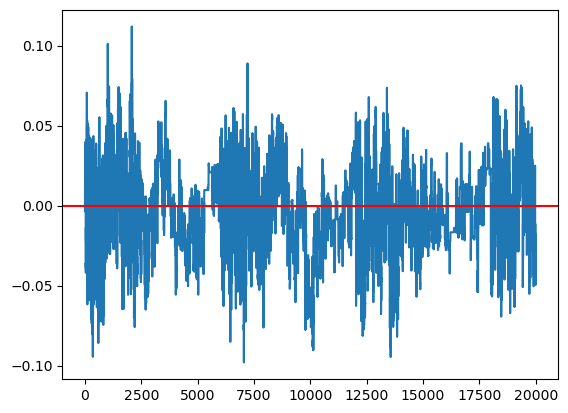

In [59]:
plt.plot(mms)
plt.axhline(mms[0],color='red')

These local steps don't scale very well to larger problems, so instead we tend to use tree-based methods like the ReCombination Markov chain to take larger steps through the state space. Let's look at an example of this with the Washington Data we've already loaded in.

In [61]:
ideal_con_population = sum(EPart["population"].values()) / len(EPart)

recom_proposal = partial(recom, pop_col="POP100", pop_target=ideal_con_population, epsilon=0.02)

compactness_bound = constraints.UpperBound(lambda p: len(p["cut_edges"]), 1.2*len(EPart['cut_edges']))


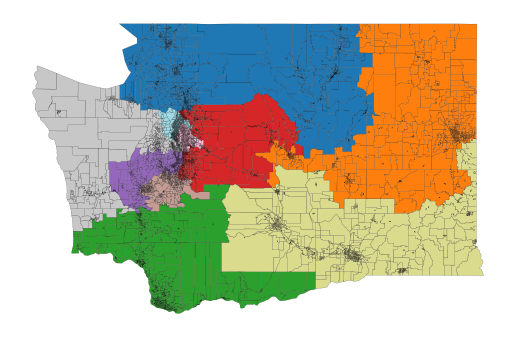

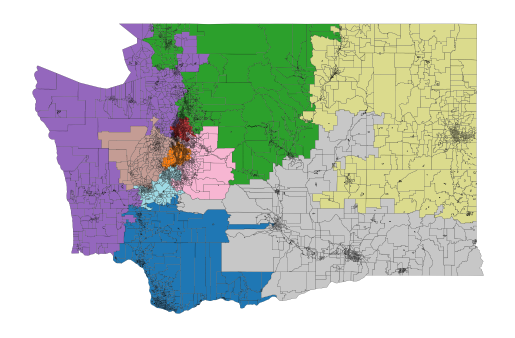

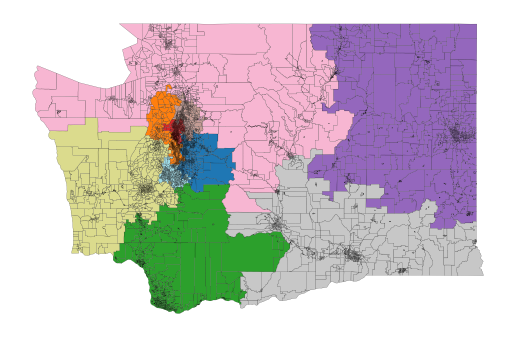

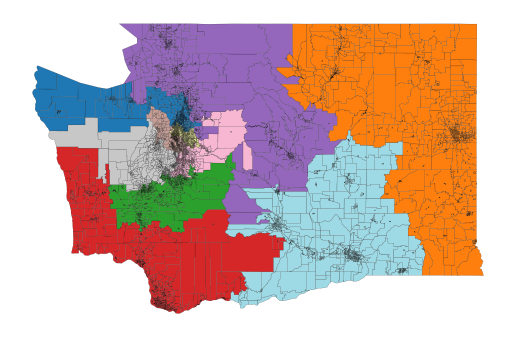

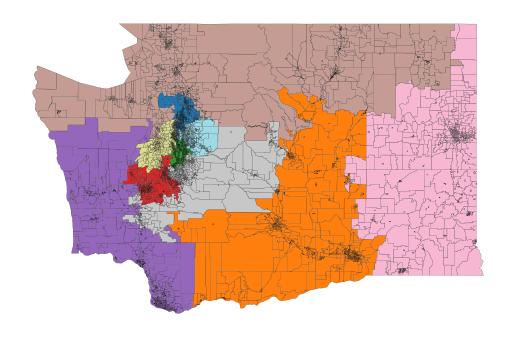

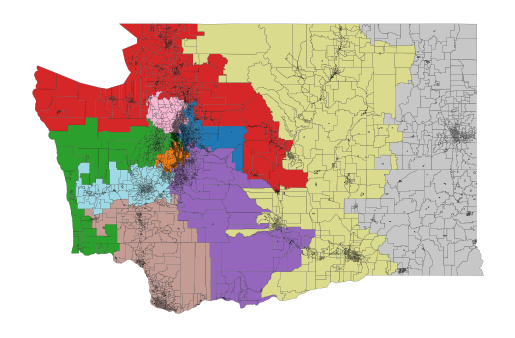

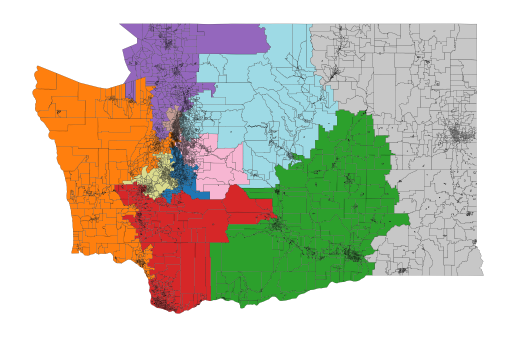

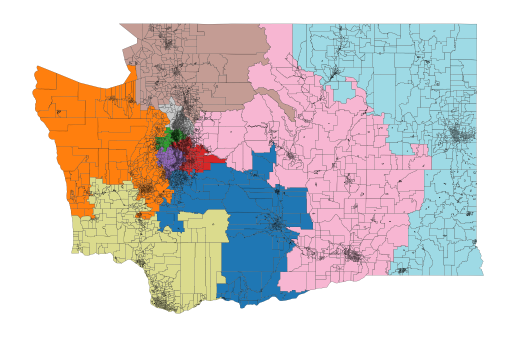

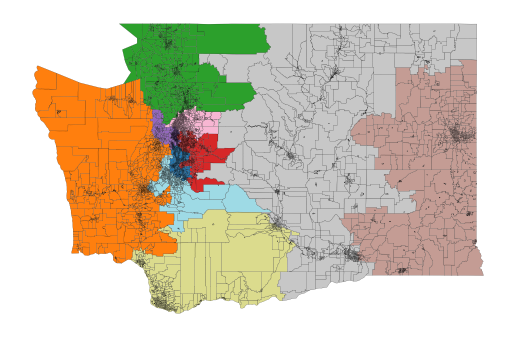

In [ ]:




splits = []
comps = []
nexts = []
percs = []
wins = []
mms = []
egs = []


recom_chain = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(EPart, 0.05),
    ],
    accept=accept.always_accept,
    initial_state=EPart,
    total_steps=1000
  )


step = 0

for current_part in recom_chain:
  splits.append(county_splits(current_part))
  comps.append(num_comp(current_part))
  nexts.append(nearest_comp_dist(current_part))
  percs.append(sorted(list(current_part['PRS'].percents('Democratic'))))
  wins.append(current_part['PRS'].wins("Democratic"))
  mms.append(mean_median(current_part['PRS']))
  egs.append(efficiency_gap(current_part['PRS']))

  step += 1
  if step%100 ==0:
    ad = dict(current_part.assignment)
    Precincts['current'] = Precincts.index.map(ad)

    Precincts.plot(column='current',cmap='tab20', edgecolor='black',linewidth=.1)
    plt.axis('off')
    plt.show()











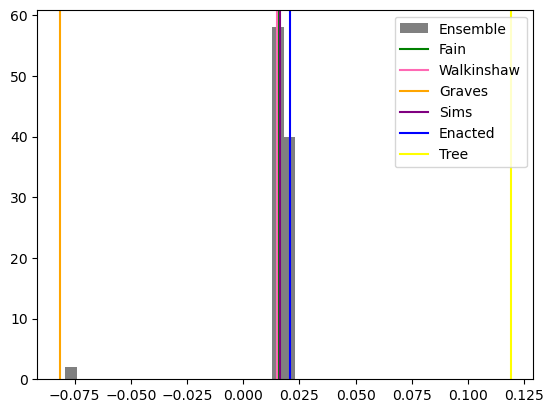

In [66]:
plt.hist(egs,color='gray',label='Ensemble',bins=20)

proposed_plans = [FPart,WPart,GPart,SPart,EPart,TPart]
plan_names = ["Fain","Walkinshaw","Graves","Sims","Enacted","Tree"]

clist = ['green','hotpink','orange','purple','blue','yellow']

for plan in range(6):
    plt.axvline(efficiency_gap(proposed_plans[plan]["PRS"]),label=plan_names[plan],color=clist[plan])
    
plt.legend()

In [ ]:
plt.hist(mms,color='gray',label='Ensemble',bins=20)

proposed_plans = [FPart,WPart,GPart,SPart,EPart,TPart]
plan_names = ["Fain","Walkinshaw","Graves","Sims","Enacted","Tree"]

clist = ['green','hotpink','orange','purple','blue','yellow']

for plan in range(6):
    plt.axvline(mean_median(proposed_plans[plan]["PRS"]),label=plan_names[plan],color=clist[plan])
    
plt.legend()

In [ ]:
plt.boxplot(np.array(percs))